In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
import sys
import seaborn as sns
import re

from fastFM import als, sgd
from fastFM.datasets import make_user_item_regression
from scipy.sparse import csc_matrix, hstack, vstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
from collections import OrderedDict

% matplotlib inline
sns.set_style('whitegrid')

# 06D - Factorization Machine - Using External Data
Because FM's allow the incorporation of additional features beyond what already exists in the Amazon Product Data used for Part I, namely user (reviewerID), item (ASIN - Amazon Standard Identification Number), and rating, we performed web scraping from different online sources in order to collect additional information about each item to feed into the factorization machine. Specifically, we collected new features from the following three sources:

1. Amazon
2. OMDB (The Open Move Database)
3. IMDB (The Internet Movie Database)

Between the three sources of data, the following features were collected and are considered here for feature engineering:

* **box office**: The amount of revenue a film has earned during its theatrical release.
* **country**: The countries in which the item has been released.
* **language**: The languages in which the item has been released.
* **metascore**: The [metacritic](http://www.metacritic.com/) score for that item (on a scale of 0 to 100).
* **mpaa rating**: The maturity rating of that item (ex: PG, PG-13, R, TV-MA, etc.)
* **runtime**: The total running time of that item.
* **type**: Whether the item is a film or TV series.
* **year**: The year in which the item was released.
* **vfx (visual effect)**: Whether the crew for that item included a visual effects department.
* **imdb genre**: The genres the item belongs to (ex: sci-fi, romance, comedy, etc).
* **imdb studios**: The production studios that created the item. This data is converted into a lemmatized [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model to account for varying studio naming conventions.
* **imdb rating**: The average rating on a scale of 1 to 10 that IMDB users assigned to the item.
* **imdb votes**: The number of IMDB users that rated the item.
* **directors**: The directors for the item.
* **amazon genre**: The primary genre the item belongs to (ex: sci-fi, romance, comedy, etc).
* **actors**: The main actors that appear in the item.
* **amazon studio**: The primary production studio that created the item. This data is similarly converted to a bag of words model.
* **amazon sales rank**: The current sales rank of that item.

### Import data
Import training, cross-validation, and test sets. We also import previously saved sparse data for all features.

In [2]:
# import full data
data_path = os.path.join('..','..', 'data-2')
splits_path = os.path.join(data_path,'splits')
sparse_path = os.path.join(data_path, 'sparse')
columns = ['user','item','rating']

with open(os.path.join(splits_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)
    
# import sparse data and store as a dictionary for easy access
sparse = dict()
features = ['actors', 'country', 'directors-imdb', 'genres-amazon', 'genres-imdb', 'language', 'mpaa',
           'studios-amazon', 'studios-imdb', 'type', 'user-item']
for feature in features:
    with open(os.path.join(sparse_path, feature + '.dict'), 'rb') as file_in:
        sparse[feature] = pkl.load(file_in)
        
# import results from LSH and Baseline
results_lsh_train = pd.read_csv(os.path.join(data_path, 'results_lsh_train.csv'))
results_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_lsh_cv.csv'))
results_lsh_test = pd.read_csv(os.path.join(data_path, 'results_lsh_test.csv'))

results_baseline_train = pd.read_csv(os.path.join(data_path, 'results_baseline_train.csv'))
results_baseline_cv = pd.read_csv(os.path.join(data_path, 'results_baseline_cv.csv'))
results_baseline_test = pd.read_csv(os.path.join(data_path, 'results_baseline_test.csv'))

train_df['pred_lsh'] = results_lsh_train['prediction'].values
train_df['pred_baseline'] = results_baseline_train['pred'].values

cv_df['pred_lsh'] = results_lsh_cv['prediction'].values
cv_df['pred_baseline'] = results_baseline_cv['pred'].values

test_df['pred_lsh'] = results_lsh_test['prediction'].values
test_df['pred_baseline'] = results_baseline_test['pred'].values

### Additional data cleaning

In [3]:
# convert years to ints
train_df['year'] = train_df['year'].apply(lambda x: x[0:4]).astype(int)
cv_df['year'] = cv_df['year'].apply(lambda x: x[0:4]).astype(int)
test_df['year'] = test_df['year'].apply(lambda x: x[0:4]).astype(int)

# normalize high variability features, but using only mean and std calculated from training set
to_normalize = list(['box_office', 'sales_rank', 'imdb_votes', 'metascore', 'runtime', 'year'])
summary_stats = dict()

for feature in to_normalize:
        summary_stats[feature] = dict(mean=train_df[feature].mean(), std=train_df[feature].std())

for dataset in list([train_df, cv_df, test_df]):    
    for feature in to_normalize:
        dataset[feature] = (dataset[feature] - summary_stats[feature]['mean']) / summary_stats[feature]['std']

# Train and test using output from LSH and Bias Baseline

In [4]:
cv_df.head(2)

item            user  rating                title  box_office  \
344665  6301327756  A3OT1WCOZLZV5D     5.0            Gunga Din         NaN   
146296  B00005JMJ4  A1E2POEKKLNLD9     5.0  Lost in Translation   -0.398036   

             country                             language  metascore  \
344665         [usa]                            [english]        NaN   
146296  [usa, japan]  [english, japanese, german, french]   1.593039   

       mpaa_rating   runtime      ...       \
344665    APPROVED  0.173298      ...        
146296           R -0.252503      ...        

                                             studios_imdb  imdb_rating  \
344665                              [rko, radio, picture]          7.5   
146296  [focus, feature, tohokushinsha, film, corporat...          7.8   

        imdb_votes         directors genres_amazon  \
344665   -0.651607  [george stevens]      [comedy]   
146296    0.841560   [sofia coppola]            []   

                                                   actors  \
344665  [cary grant, joan fontaine, victor mclaglen, d...   
146296  [bill murray, scarlett johansson, giovanni rib...   

                                  studios_amazon sales_rank  pred_lsh  \
344665                     [warner, home, video]   0.483784  4.628662   
146296  [universal, studio, home, entertainment]  -0.549850  3.178086   

       pred_baseline  
344665      4.763798  
146296      3.027001  

[2 rows x 24 columns]

As before, we use Hyperopt for the hyperparameter search, which necessitates defining an objective function **test_fm** to be minimized. Feature engineering is automated as part of the hyperparameter search by treating the decision of whether or not to include a feature in the dataset as a hyperparameter. **build_data** constructs the specified training, CV, and test data depending on how its hyperparameters are set.

In [5]:
def build_data(use_actors, use_country, use_directors, use_genres, use_language, use_mpaa, use_studios, use_type,
               use_scores, use_popularity, use_year, use_model_results):
    
    # copy unconverted data into a dictionary
    X_orig = dict(train=train_df, cv=cv_df, test=test_df)
    
    datasets = ['train', 'cv', 'test'] # keys for the 'X' and 'y' dictionaries
    X = dict() # For each dataset, stores all features as one large sparse matrix
    y = dict() # For each dataset, stores true ratings
    
    # always include user-item data in datasets
    for dataset in datasets:
        X[dataset] = sparse['user-item'][dataset]
        y[dataset] = X_orig[dataset]['rating']
    
    # maintain an ordered list of column names that can be matched back to each the sparse matrices if needed
    X['columns'] = list()
    
    # maintain lists of sparse and dense features to be added to data in 'X'
    sparse_features = list()
    dense_features = list()
    
    if use_actors: sparse_features.append('actors')
    if use_country: sparse_features.append('country')
    if use_directors: sparse_features.append('directors-imdb')
    if use_genres:
        sparse_features.extend(['genres-amazon','genres-imdb'])
        dense_features.append('vfx')
    if use_language: sparse_features.append('language')
    if use_mpaa: sparse_features.append('mpaa')
    if use_studios: sparse_features.extend(['studios-amazon','studios-imdb'])
    if use_type:
        sparse_features.append('type')
        dense_features.append('runtime')
    if use_scores: dense_features.extend(['metascore','imdb_rating'])
    if use_popularity: dense_features.extend(['imdb_votes','sales_rank','box_office'])
    if use_year: dense_features.append('year')
    if use_model_results: dense_features.extend(['pred_lsh', 'pred_baseline'])
    
    # add sparse features to each dataset in 'X'
    for feature in sparse_features:
        X['columns'] += list(sparse[feature]['columns'])
        for dataset in datasets:
            X[dataset] = hstack([X[dataset], sparse[feature][dataset]])
    
    # add dense features to each dataset in 'X'
    for feature in dense_features:
        X['columns'].append(feature)
        for dataset in datasets:
            new_data = X_orig[dataset][feature]
            median = new_data.quantile(0.5)
            new_data = new_data.fillna(median).values
            new_data = new_data.reshape(X_orig[dataset].shape[0],-1)
            X[dataset] = hstack([X[dataset], new_data])
            
    return X, y    

In [6]:
# define the objective function that the fmin module can later optimize on
def test_fm(params):
    
    # convert certain hyperparameter values to integers
    print('==========TESTING FM==========')
    params['n_iter'] = int(params['n_iter'])
    params['rank'] = int(params['rank'])
    print(params)
    
    fm = als.FMRegression(n_iter=params['n_iter'],
                          rank=params['rank'],
                          init_stdev=params['init_stdev'],
                          l2_reg_w=params['l2_reg_w'],
                          l2_reg_V=params['l2_reg_V'])
    
    X, y = build_data(use_actors=params['use_actors'],
                      use_country=params['use_country'],
                      use_directors=params['use_directors'],
                      use_genres=params['use_genres'],
                      use_language=params['use_language'],
                      use_mpaa=params['use_mpaa'],
                      use_studios=params['use_studios'],
                      use_type=params['use_type'],
                      use_scores=params['use_scores'],
                      use_popularity=params['use_popularity'],
                      use_year=params['use_year'],
                      use_model_results=params['use_model_results'])

    # train model and evaluate MAE on cross-validation set
    fm.fit(X['train'], y['train'])
    y_cv_pred = fm.predict(X['cv'])
    print('HERE')
    print(y_cv_pred)
    mae = mean_absolute_error(y_cv_pred, y['cv'])
    print('MAE:', mae)
    return mae

In [7]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_fm_external.txt'), 'rt') as file_in:
        trials = file_in.read()
else:
    # set hyperparameter ranges
    trials = Trials()
    space = {
        'n_iter': hp.uniform('n_iter', 700, 1300), # Number of ALS parameter updates
        'init_stdev': hp.uniform('init_stdev', 0, 1), # The standard deviation of initialized parameters
        'rank': hp.uniform('rank', 2, 2), # The rank of the factorization used for the second order interactions
        'l2_reg_w': hp.uniform('l2_reg_w', 10, 31), # L2 penalty weight for linear coefficients
        'l2_reg_V': hp.uniform('l2_reg_V', 10, 31), # L2 penalty weight for pairwise coefficients
        'use_actors': hp.choice('use_actors', [False,True]), # Whether to include actors as a feature in the FM model
        'use_country': hp.choice('use_country', [False,True]), # Whether to include country as a feature in the FM model
        'use_directors': hp.choice('use_directors', [False,True]), # Whether to include directors as a feature in the FM model
        'use_genres': hp.choice('use_genres', [False,True]), # Whether to include genres as a feature in the FM model
        'use_language': hp.choice('use_language', [False,True]), # Whether to include language as a feature in the FM model
        'use_mpaa': hp.choice('use_mpaa', [False,True]), # Whether to include mpaa rating as a feature in the FM model
        'use_studios': hp.choice('use_studios', [False,True]), # Whether to include production studios as a feature in the FM model
        'use_type': hp.choice('use_type', [False,True]), # Whether to include item type (movie, episode, series, game) as a feature in the FM model
        'use_scores': hp.choice('use_scores', [False,True]), # Whether to include metascore and imdb score as features in the FM model
        'use_popularity': hp.choice('use_popularity', [False,True]), # Whether to include popularity metrics (imdb votes, Amazon sales rank, and box office) as features in the FM model
        'use_year': hp.choice('use_year', [False,True]), # Whether to include release year as a feature in the FM model
        'use_model_results': hp.choice('use_model_results', [False,True]) # Whether to include results from LSH and bias baseline models as features in the FM model
    }
    
    # Choose the Tree-structured Parzen Estimator (TPE) as the algorithm to optimize the objective function
    best = fmin(algo = tpe.suggest,
               fn = test_fm,
               trials = trials,
               max_evals = 50, # max number of tests
               space = space)
    with open(os.path.join(data_path, 'trials_fm_external'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_fm_external.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

Given the large number of hyperparameters, the search was originally set for 300 evaluations. However, as this was taking far too long, the search was aborted after 102 evaluations. The output printed during the search process was saved and scraped to recover performance data from each trial and hyperparameter configuration.

In [8]:
# find all hyperparameter dictionaries from saved console output
param_dicts_regex = re.compile(r'({.*})')
matches = re.findall(param_dicts_regex, trials)
param_dicts = [eval(x) for x in matches][:-1]

# find all MAE results from saved console output
mae_regex = re.compile(r'MAE: (\d*\.\d*)')
matches = re.findall(mae_regex, trials)
for mae, param_dict in zip(matches, param_dicts):
    param_dict['mae'] = mae

Data from the partial search is plotted below.

- The first plot of each row shows the hyperparameter value tested at each iteration. As TPE discovers which value is more effective, it narrows its search region, which is more evident in later hyperparameters.
- The second plot of each row shows the frequency with which a particular hyperparameter value is tested. TPE tends to sample more frequently from regions where model performance is better.
- The third plot of each row shows the various loss values associated with a given hyperparameter value. The loss value is MAE of the model's predictions on the cross-validation set using a given hyperparameter configuration.

In [10]:
def val_diagnostic(val_name, param_dicts):
    '''generates scatter plot and histogram of each parameter, as well as a plot on loss values (MAE)'''
    
    vals = np.array([x[val_name] for x in param_dicts])
    maes = np.array([x['mae'] for x in param_dicts])
    
    # convert certain hyperparameter values to integers
    if val_name in ['n_iter', 'rank']:
        vals = [int(x) for x in vals]
    if isinstance(vals[0], np.bool_):
        vals = [int(x) for x in vals]
        
    ts = list(range(1, len(vals)+1))
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, maes)
    axes[2].set(xlabel=val_name, ylabel='loss', ylim=(0.7, 0.75))
    plt.tight_layout()

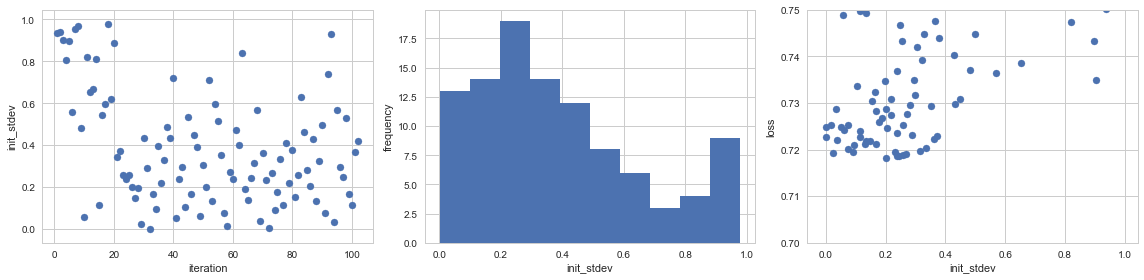

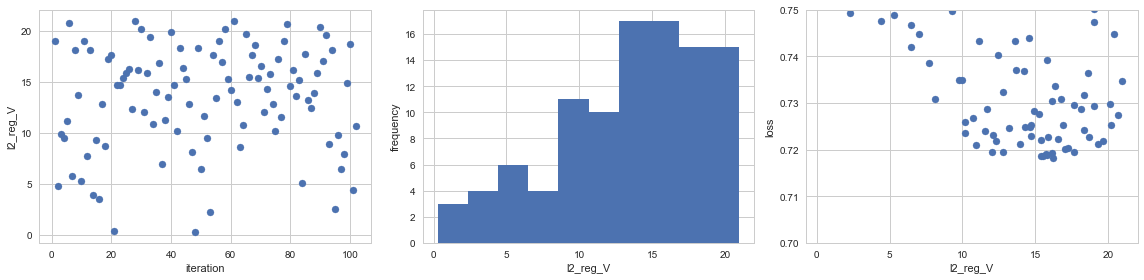

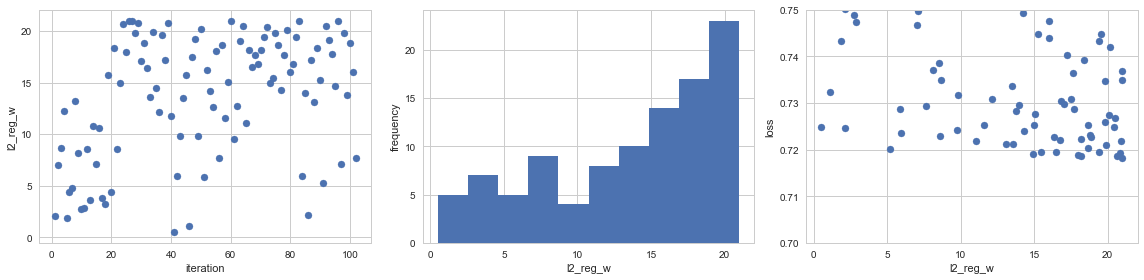

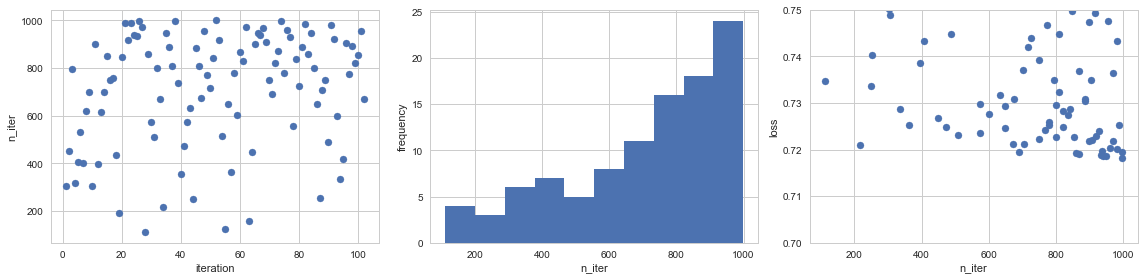

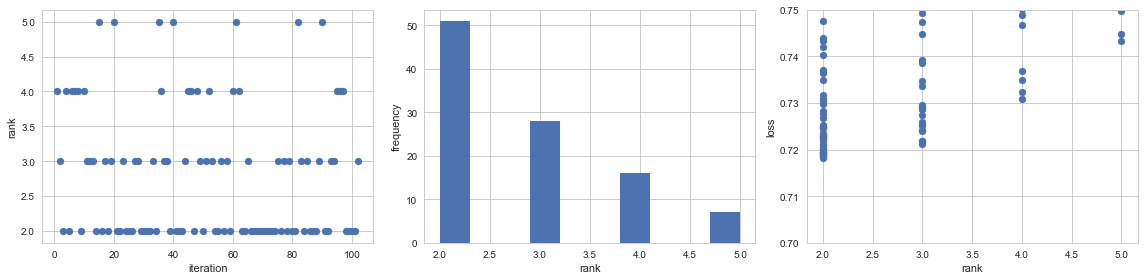

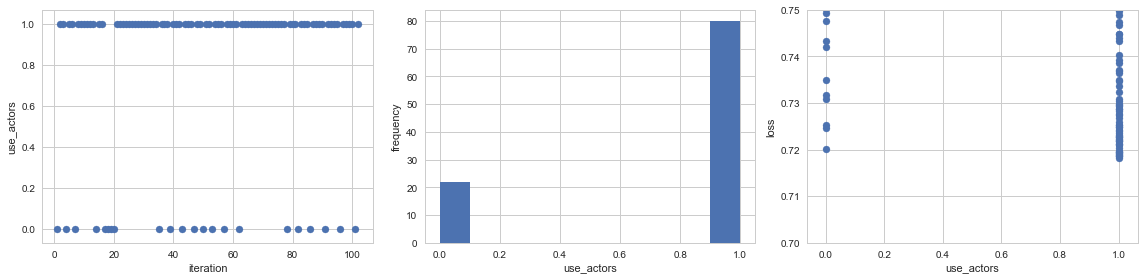

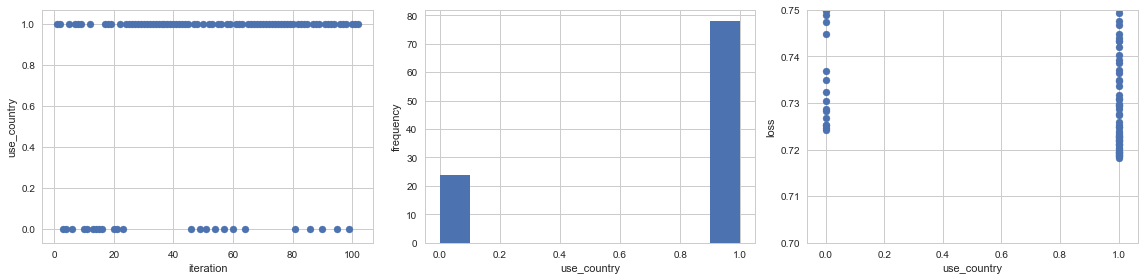

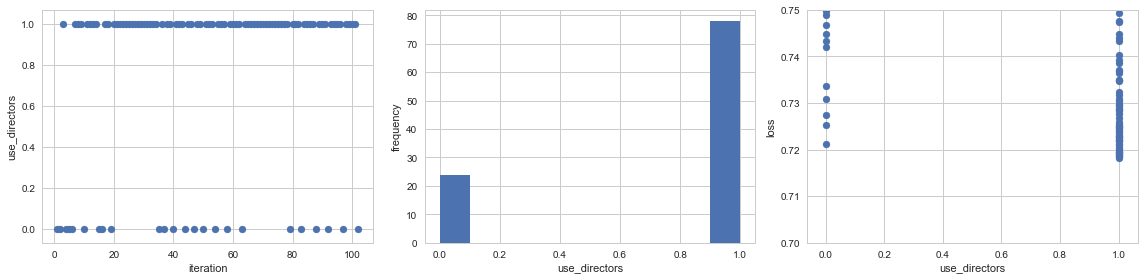

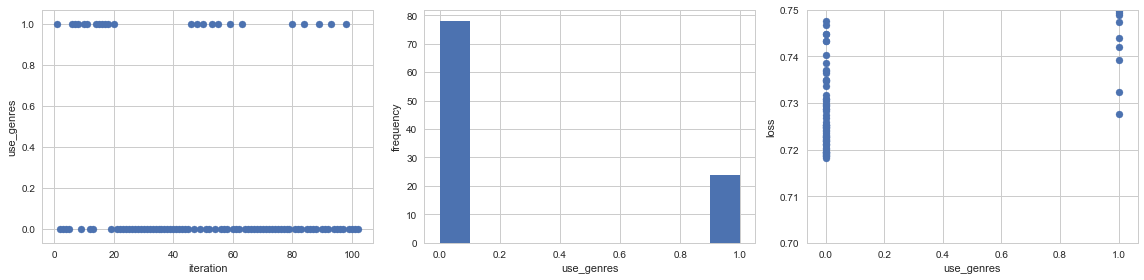

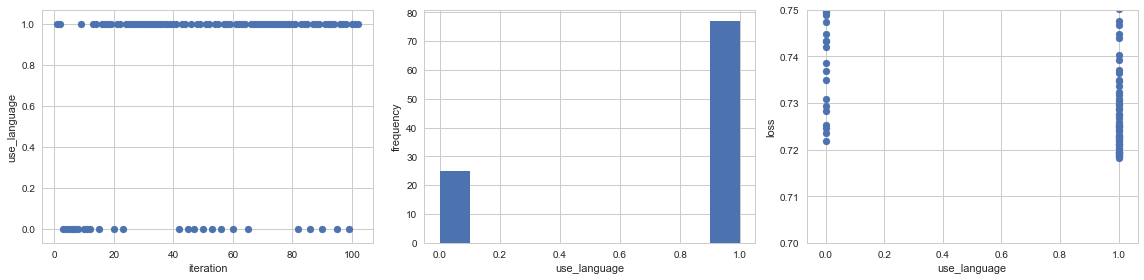

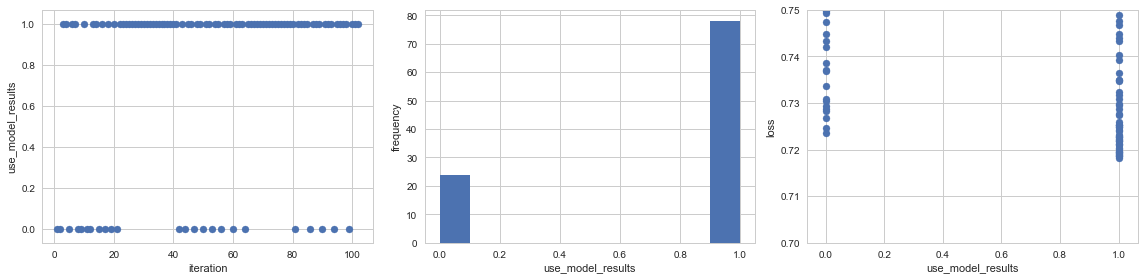

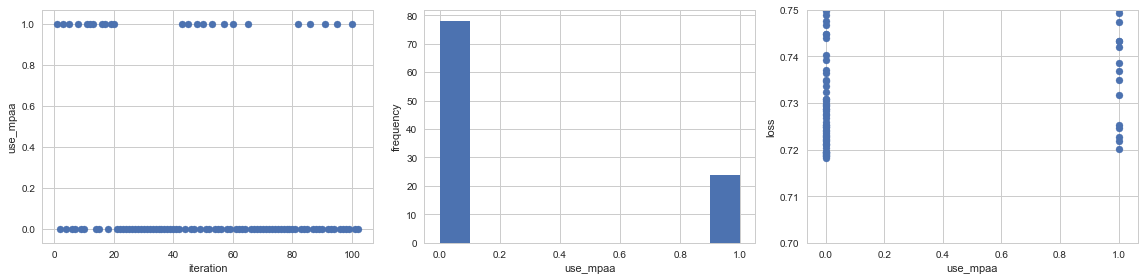

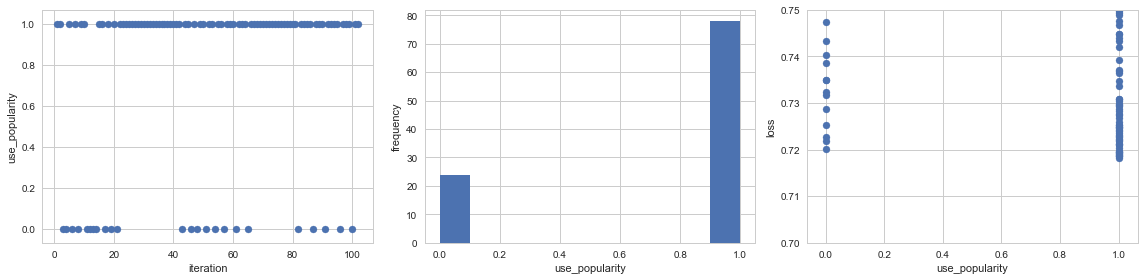

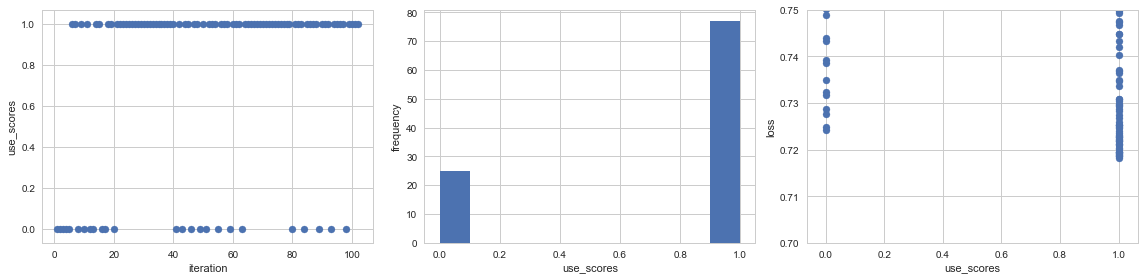

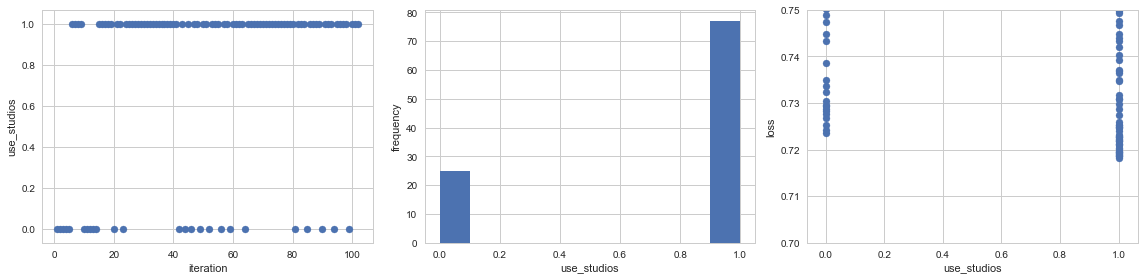

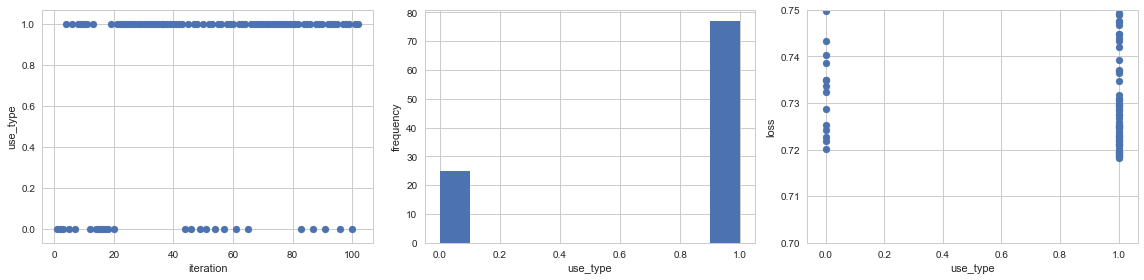

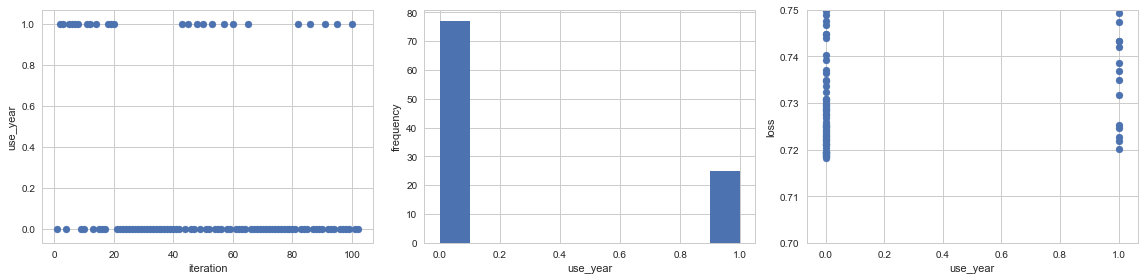

In [11]:
for val_name in param_dicts[0].keys():
    if val_name != 'mae':
        val_diagnostic(val_name, param_dicts)

With the exception of genres, release year, and MPAA rating, all other features contribute to the best model the hyperparameter search can find. Interestingly, despite the inclusion of a number of new features, an FM model with a rank of 2 still provides the best results, provided a high degree of regularization is used for both linear and second-order coefficients.

Using the optimal hyperparameters found during the previous search, we train a final model, use it to generate predictions for the train, CV, and test sets, and save the results.

In [25]:
use_pretrained = True

if use_pretrained:
    train_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_external_train.csv'))
    cv_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_external_cv.csv'))
    test_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_external_test.csv'))
else:
    X, y = build_data(use_actors=True, use_country=True, use_directors=True, use_genres=False,
                 use_language=True, use_mpaa=False, use_studios=True, use_type=True,
                 use_scores=True, use_popularity=True, use_year=False, use_model_results=True)

    fm = als.FMRegression(n_iter=997,
                          init_stdev=0.2019066648748623,
                          rank=2,
                          l2_reg_w=16.225155226803963,
                          l2_reg_V=20.97517698433272)
    fm.fit(X['train'], y['train'])
    y_train_pred = fm.predict(X['train'])
    y_cv_pred = fm.predict(X['cv'])
    y_test_pred = fm.predict(X['test'])
    
    train_results_df = train_df[['user','item','rating']].copy()
    train_results_df['prediction'] = y_train_pred
    train_results_df.to_csv(os.path.join(data_path, 'results_fm_external_train.csv'), header=True, index=False)
    
    cv_results_df = cv_df[['user','item','rating']].copy()
    cv_results_df['prediction'] = y_cv_pred
    cv_results_df.to_csv(os.path.join(data_path, 'results_fm_external_cv.csv'), header=True, index=False)
    
    test_results_df = test_df[['user','item','rating']].copy()
    test_results_df['prediction'] = y_test_pred
    test_results_df.to_csv(os.path.join(data_path, 'results_fm_external_test.csv'), header=True, index=False)

### Mean absolute error
Below we plot the MAE of the tuned model for the train, CV, and test sets.

mean absolute error, training set: 0.6503970841384533
mean absolute error, cross-validation set: 0.7096352711843781
mean absolute error, test set: 0.7056455619381665


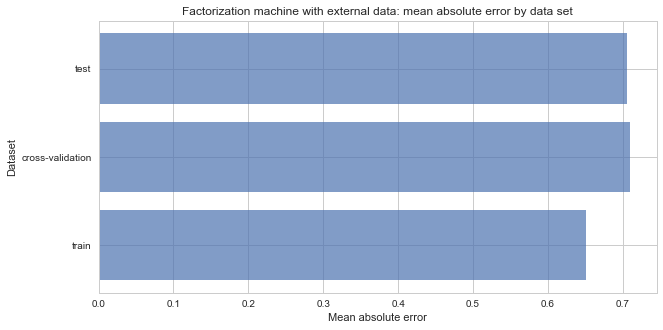

In [26]:
# Some predictions exceed the permitted range of 1 to 5.
# All predicted values less than 1 are converted 1, and all predicted values greater than 5 are converted to 5.
y_train_pred = np.clip(train_results_df['prediction'], a_min=1, a_max=5)
y_cv_pred = np.clip(cv_results_df['prediction'], a_min=1, a_max=5)
y_test_pred = np.clip(test_results_df['prediction'], a_min=1, a_max=5)

# Calculate and print MAE
mae_train = np.abs(train_results_df['rating'] - y_train_pred).mean()
mae_cv = np.abs(cv_results_df['rating'] - y_cv_pred).mean()
mae_test = np.abs(test_results_df['rating'] - y_test_pred).mean()

print('mean absolute error, training set:', mae_train)
print('mean absolute error, cross-validation set:', mae_cv)
print('mean absolute error, test set:', mae_test)

mae_list = [mae_train, mae_cv, mae_test]

# plot results
plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], mae_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'Factorization machine with external data: mean absolute error by data set',
              ylabel = 'Dataset', xlabel = 'Mean absolute error')

### AUROC score
Below we plot the AUC of the tuned model for the train, CV, and test sets. 

ROC AUC, training set: 0.861593125304
ROC AUC, cross-validation set: 0.823384309256
ROC AUC, test set: 0.827127609009


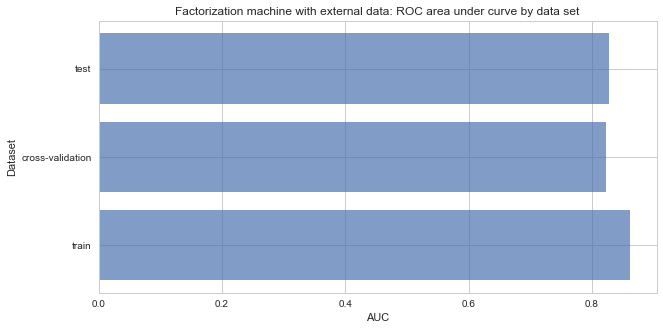

In [27]:
def calc_auc(data):
    y = data['rating'] >= 4
    y_pred = np.clip(data['prediction'], a_min=1, a_max=5)
    y_pred = y_pred / y_pred.max()
    auc = roc_auc_score(y, y_pred)
    return auc

auc_train = calc_auc(train_results_df)
auc_cv = calc_auc(cv_results_df)
auc_test = calc_auc(test_results_df)

print('ROC AUC, training set:', auc_train)
print('ROC AUC, cross-validation set:', auc_cv)
print('ROC AUC, test set:', auc_test)

auc_list = [auc_train, auc_cv, auc_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], auc_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'Factorization machine with external data: ROC area under curve by data set',
              ylabel = 'Dataset', xlabel = 'AUC')